In [29]:
import os
import numpy as np
import pandas as pd
from glob import glob
import cv2
import torch
from torch.utils import data
from PIL import Image
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt



gttext = np.genfromtxt('data/gt.txt',delimiter =';', dtype= None,encoding=None)

# Dictionary for storing image names, their bounding box coordinates and labels
dic ={}
cls=np.zeros(43)
for i in range (len(gttext)):
    
    # Image number
    im = gttext[i][0]
    
    # Bounding box Coordinates
    bbox = [gttext[i][1],gttext[i][2],gttext[i][3],gttext[i][4],gttext[i][5]]
    
    # Label number
    label = gttext[i][-1]
    cls[label]+=1
    
    # If image has multiple objects, store all coordinates and labels 
    if(im in dic):
        dic[im].append(bbox)
    else:
        dic[im] = [bbox]
        
        
print(dic['00001.ppm'][:])
print(dic['00001.ppm'])
print("Number of Images: " + str(len(dic)))


#Data Distribution


[[983, 388, 1024, 432, 40], [386, 494, 442, 552, 38], [973, 335, 1031, 390, 13]]
[[983, 388, 1024, 432, 40], [386, 494, 442, 552, 38], [973, 335, 1031, 390, 13]]
Number of Images: 741


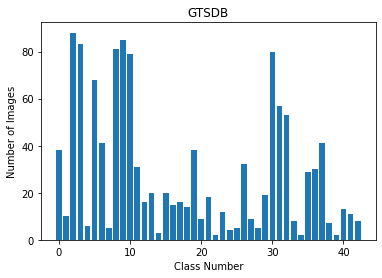

In [41]:
clsNum = [i for i in range(43)]
imgNum = []
clist = {}
for i in dic:
    for k in range(len(dic[i])):
        label = dic[i][:][k][-1]
        if label in clist:
            clist[label] += 1
        else:
            clist[label] = 1

for i in clist:
    imgNum.append(clist[i])

plt.bar(clsNum, imgNum)
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.title("GTSDB")
plt.show()

In [42]:
# Copy images that are annotated only in a new file for training
import shutil

for i in range(len(dic)):
    ofile = r'./data/train/images/{}'.format(list(dic)[i])
    target = r'./data/train/imgtrain/{}'.format(list(dic)[i])
    shutil.copyfile(ofile, target)


In [48]:
class DefineDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imgtrain"))))
 
    def __getitem__(self, idx):
        # Load image path
        img_path = os.path.join(self.root, "imgtrain", self.imgs[idx])
        #Load image as PIL
        img = Image.open(img_path).convert("RGB")        
        # Get objects in the image
        objects = dic[self.imgs[idx]]
        # Get bounding box coordinates for each object in image
        boxes = []
        labels = []
        for obj in objects:
            #print(idx, obj[-1], self.imgs)
            name = obj[-1]
            labels.append(np.int(name))
            #Get bounding box coordinates
            xmin = np.float(obj[0])
            ymin = np.float(obj[1])
            xmax = np.float(obj[2])
            ymax = np.float(obj[3])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)        
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(objects),), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [49]:
from engine import train_one_epoch, evaluate
import utilss
import torch.nn as nn
import transforms as T
from engine import train_one_epoch, evaluate

def GetTransform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
 
    return T.Compose(transforms)

# Data directory
path = r'./data/train'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 44
# Send the annotated image data to the DefineDataset class 
dataset = DefineDataset(path, GetTransform(train=True))
test = DefineDataset(path, GetTransform(train=False))

# Splitting into train and test 
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
test = torch.utils.data.Subset(test, indices[-100:])

# Training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, 
    collate_fn=utilss.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    test, batch_size=2, shuffle=False, 
    collate_fn=utilss.collate_fn)

# Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)
model.to(device)

print("Model loaded")

Model loaded


In [51]:
from engine import train_one_epoch, evaluate
from IPython.display import clear_output
import pickle


# Model parameters
params = [p for p in model.parameters() if p.requires_grad]

# Optimizer
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

# Training
num_epochs = 5

# Loss variables for plotting
losses = []
loss_box_reg = []
loss_rpn_box_reg = []
loss_classifier = []
loss_objectness = []

stat0 = []
stat1 = []
stat2 = []
stat3 = []
stat4 = []
stat5 = []
stat6 = []
stat7 = []
stat8 = []
stat9 = []
stat10 = []
stat11 = []


for epoch in range(num_epochs):
    # Detection evaluation metrics used by COCO.
    metrics = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    losses.append(float(str(metrics.meters['loss']).split(" ")[0]))
    loss_box_reg.append(float(str(metrics.meters['loss_box_reg']).split(" ")[0]))
    loss_rpn_box_reg.append(float(str(metrics.meters['loss_rpn_box_reg']).split(" ")[0]))
    loss_classifier.append(float(str(metrics.meters['loss_classifier']).split(" ")[0]))
    loss_objectness.append(float(str(metrics.meters['loss_objectness']).split(" ")[0]))
    
    scheduler.step()

    # Evaluate on the test dataset
    _, metric_logger = evaluate(model, data_loader_test, device=device)
    stat = _.coco_eval['bbox'].stats
    
    #Append all stats
    stat0.append(stat[0])
    stat1.append(stat[1])
    stat2.append(stat[2])
    stat3.append(stat[3])
    stat4.append(stat[4])
    stat5.append(stat[5])
    stat6.append(stat[6])
    stat7.append(stat[7])
    stat8.append(stat[8])
    stat9.append(stat[9])
    stat10.append(stat[10])
    stat11.append(stat[11])
    
    
    print('')
    print('==================================================')
    print('')

print("Done!")

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [  0/321]  eta: 0:02:38  lr: 0.000002  loss: 4.5134 (4.5134)  loss_classifier: 3.7659 (3.7659)  loss_box_reg: 0.0393 (0.0393)  loss_objectness: 0.6969 (0.6969)  loss_rpn_box_reg: 0.0112 (0.0112)  time: 0.4923  data: 0.0256  max mem: 2582
Epoch: [0]  [ 50/321]  eta: 0:01:43  lr: 0.000080  loss: 2.9983 (3.7703)  loss_classifier: 2.2988 (3.0251)  loss_box_reg: 0.0205 (0.0369)  loss_objectness: 0.6932 (0.6948)  loss_rpn_box_reg: 0.0075 (0.0134)  time: 0.3827  data: 0.0351  max mem: 2846
Epoch: [0]  [100/321]  eta: 0:01:24  lr: 0.000158  loss: 0.2631 (2.2799)  loss_classifier: 0.0922 (1.6892)  loss_box_reg: 0.0120 (0.0271)  loss_objectness: 0.1320 (0.5472)  loss_rpn_box_reg: 0.0058 (0.0163)  time: 0.3841  data: 0.0319  max mem: 2846
Epoch: [0]  [150/321]  eta: 0:01:05  lr: 0.000236  loss: 0.3835 (1.6264)  loss_classifier: 0.1923 (1.1781)  loss_box_reg: 0.0832 (0.0345)  loss_objectness: 0.0612 (0.3984)  loss_rpn_box_reg: 0.0078 (0.0154)  time: 0.3821  data: 0.0315  max mem: 2846


Epoch: [2]  [250/321]  eta: 0:00:26  lr: 0.000250  loss: 0.2940 (0.3243)  loss_classifier: 0.1688 (0.1756)  loss_box_reg: 0.1190 (0.1267)  loss_objectness: 0.0069 (0.0138)  loss_rpn_box_reg: 0.0057 (0.0083)  time: 0.3772  data: 0.0278  max mem: 2846
Epoch: [2]  [300/321]  eta: 0:00:07  lr: 0.000250  loss: 0.2849 (0.3211)  loss_classifier: 0.1581 (0.1735)  loss_box_reg: 0.1118 (0.1258)  loss_objectness: 0.0084 (0.0135)  loss_rpn_box_reg: 0.0056 (0.0083)  time: 0.3762  data: 0.0269  max mem: 2846
Epoch: [2]  [320/321]  eta: 0:00:00  lr: 0.000250  loss: 0.2564 (0.3199)  loss_classifier: 0.1419 (0.1725)  loss_box_reg: 0.1061 (0.1254)  loss_objectness: 0.0085 (0.0136)  loss_rpn_box_reg: 0.0048 (0.0084)  time: 0.3658  data: 0.0257  max mem: 2846
Epoch: [2] Total time: 0:02:00 (0.3754 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:11  model_time: 0.1676 (0.1676)  evaluator_time: 0.0151 (0.0151)  time: 0.2201  data: 0.0331  max mem: 2846
Test:  [49/50]  eta: 0:00:00  model_

DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.442
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.533


Done!

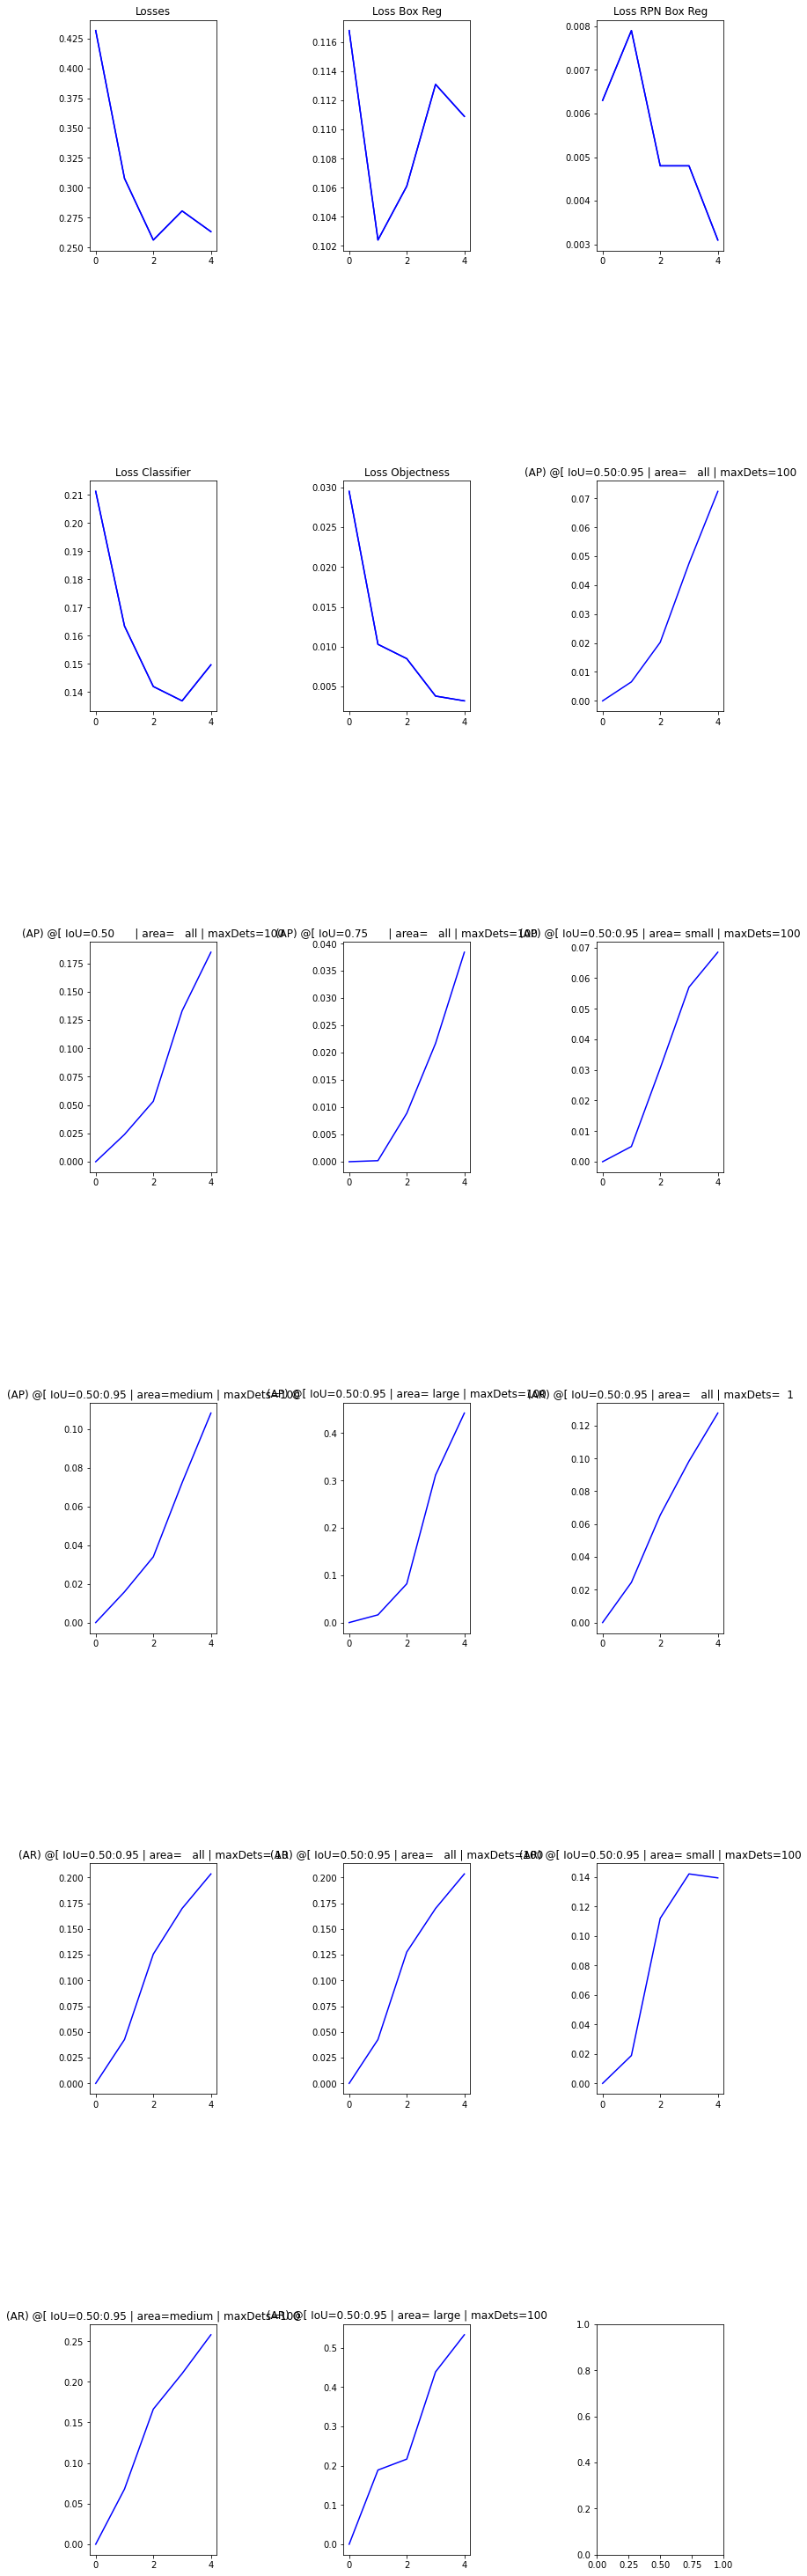

In [52]:
r,c = 9,2
fig, ax = plt.subplots(nrows=r, ncols=c)
fig.set_figheight(40)
fig.set_figwidth(10)
fig.subplots_adjust(left=14,right=15, top=6, bottom=5, hspace=1, wspace=1)


ax1 = plt.subplot(r, c, 1)
ax1.set_title("Losses")
ax2 = plt.subplot(r, c, 2)
ax2.set_title("Loss Box Reg")
ax3 = plt.subplot(r, c, 3)
ax3.set_title("Loss RPN Box Reg")
ax4 = plt.subplot(r, c, 4)
ax4.set_title("Loss Classifier")
ax5 = plt.subplot(r, c, 5)
ax5.set_title("Loss Objectness")
ax6 = plt.subplot(r, c, 6)
ax6.set_title("(AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100")
ax7 = plt.subplot(r, c, 7)
ax7.set_title("(AP) @[ IoU=0.50      | area=   all | maxDets=100")
ax8 = plt.subplot(r, c, 8)
ax8.set_title("(AP) @[ IoU=0.75      | area=   all | maxDets=100")
ax9 = plt.subplot(r, c, 9)
ax9.set_title("(AP) @[ IoU=0.50:0.95 | area= small | maxDets=100")
ax10 = plt.subplot(r, c, 10)
ax10.set_title("(AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100")
ax11 = plt.subplot(r, c, 11)
ax11.set_title("(AP) @[ IoU=0.50:0.95 | area= large | maxDets=100")
ax12 = plt.subplot(r, c, 12)
ax12.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1")
ax13 = plt.subplot(r, c, 13)
ax13.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10")
ax14 = plt.subplot(r, c, 14)
ax14.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100")
ax15 = plt.subplot(r, c, 15)
ax15.set_title("(AR) @[ IoU=0.50:0.95 | area= small | maxDets=100")
ax16 = plt.subplot(r, c, 16)
ax16.set_title("(AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100")
ax17 = plt.subplot(r, c, 17)
ax17.set_title("(AR) @[ IoU=0.50:0.95 | area= large | maxDets=100")

ax1.plot(losses, 'b')
ax2.plot(loss_box_reg, 'b')
ax3.plot(loss_rpn_box_reg, 'b')
ax4.plot(loss_classifier, 'b')
ax5.plot(loss_objectness, 'b')
ax1.plot(losses, 'b')
ax2.plot(loss_box_reg, 'b')
ax3.plot(loss_rpn_box_reg, 'b')
ax4.plot(loss_classifier, 'b')
ax5.plot(loss_objectness, 'b')
ax6.plot(stat0, 'b')
ax7.plot(stat1, 'b')
ax8.plot(stat2, 'b')
ax9.plot(stat3, 'b')
ax10.plot(stat4, 'b')
ax11.plot(stat5, 'b')
ax12.plot(stat6, 'b')
ax13.plot(stat7, 'b')
ax14.plot(stat8, 'b')
ax15.plot(stat9, 'b')
ax16.plot(stat10, 'b')
ax17.plot(stat11, 'b')
plt.show()